<a href="https://colab.research.google.com/github/ShawnLiu119/Recommendation_ML_CB-CF-Hyb/blob/main/Recommendation_CB_CF_Hyb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Overview all regular recommendation system approach - CB/CF/Hybrid**

### **Term** <br>
**content based** should give you pretty safe recommendations. However, they may bound to what you already know your customers like.

**collaborative filtering approach** recommends items liked by customers whose choice is similar to yours

**cold start** for that particular customer or that particular item, meaning that you could not educatedly predict someone without knowing even a thing of that person: a **knowledge-based approach** would do the job to find out something of the newcomers by you **sending out questionnaire** to collect their personal preference with their consent.

**Recommendation strategy is dependent on how much you know your customers**

data summary<br>

 It contains events that a **customer view / add-to-cart / purchase an item**[INTERACTION], and the category hierarchy for each of the items. The ~235000 items are categorized in ~1300 categories and these categories are further grouped into some ~400 parent categories.
 https://medium.com/analytics-vidhya/content-based-collaborative-and-their-hybrid-approaches-for-recommendation-making-to-e-commence-e2015830a04f

Reference:https://github.com/recommenders-team/recommenders

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/kaggle_data/retail_recom'

category_tree = pd.read_csv(path + '/category_tree.csv')
events = pd.read_csv(path + '/events.csv')
item_properties_1 = pd.read_csv(path + '/item_properties_part1.csv')
item_properties_2 = pd.read_csv(path + '/item_properties_part2.csv')

### 2.EDA

In [4]:
category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [5]:
category_tree.groupby('parentid').size().sort_values(ascending=False).head(10)

parentid
250.0     31
1009.0    22
362.0     22
351.0     19
1259.0    18
1687.0    17
945.0     15
312.0     15
92.0      13
1482.0    13
dtype: int64

In [6]:
events.event.value_counts()

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64

In [7]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [8]:
events[events.transactionid.notnull()]['event'].value_counts()
#Transaction ID will only have value if the user made a purchase as shown below

event
transaction    22457
Name: count, dtype: int64

In [9]:
item_properties_1.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


Item id will be the unique item identifier <br>
Property is the Item's attributes such as category id and availability while the rest are hashed for confidentiality purposes<br>
Value is the item's property value e.g. availability is 1 if there is stock and 0 otherwise<br>
Values that start with "n" indicate that the value preceeding it is a number e.g. n277.200 is equal to 277.2

In [10]:
item = pd.concat([item_properties_1, item_properties_2])
item.shape

(20275902, 4)

In [11]:
#transform timestamp into time

def convert_timestamp(df, column):
    df['datetime'] = pd.to_datetime(df[column], unit='ms')
    return df

convert_timestamp(events, 'timestamp')
convert_timestamp(item, 'timestamp')

,timestamp,itemid,property,value,datetime
0,1435460400000,460429,categoryid,1338,2015-06-28 03:00:00
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 03:00:00
2,1439089200000,395014,400,n552.000 639502 n720.000 424566,2015-08-09 03:00:00
3,1431226800000,59481,790,n15360.000,2015-05-10 03:00:00
4,1431831600000,156781,917,828513,2015-05-17 03:00:00
...,...,...,...,...,...
9275898,1433646000000,236931,929,n12.000,2015-06-07 03:00:00
9275899,1440903600000,455746,6,150169 639134,2015-08-30 03:00:00
9275900,1439694000000,347565,686,610834,2015-08-16 03:00:00
9275901,1433646000000,287231,867,769062,2015-06-07 03:00:00


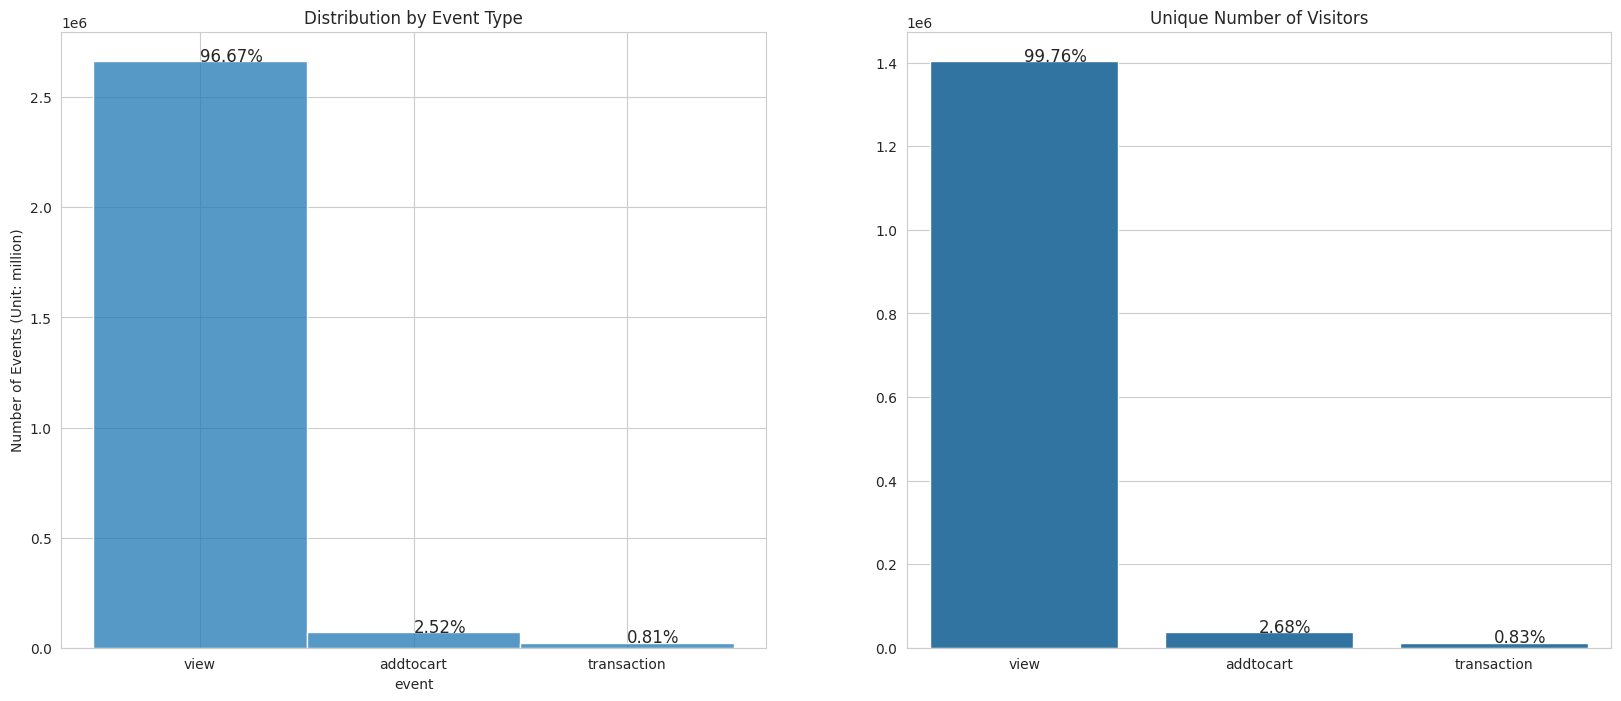

In [12]:
sns.set_style('whitegrid')

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8))
sns.histplot(x = 'event', data = events, bins = 3, ax = ax1)
totalcases = len(events)

ax1.set_ylabel('Number of Events (Unit: million)')
ax1.set_title('Distribution by Event Type')
for x, counts in zip(events['event'].unique().tolist(), events['event'].value_counts().tolist()): #index and value to list
    text=str(round((counts/totalcases)*100,2)) +'%'
    ax1.text(x, counts, text, fontsize=12)


# unique number of visitors by event

event_list = events['event'].unique().tolist()
unique_num = []
ratios = []
for e in event_list:
    uni_visit = events['visitorid'][events['event']==e].nunique()
    unique_num.append(uni_visit)
    ratios.append(uni_visit/events['visitorid'].nunique())

sns.barplot(x = event_list, y = unique_num, ax = ax2)

ratio_p = [str(round(r*100,2)) + '%' for r in ratios]
for e, c, r in zip(range(3), unique_num, ratio_p): #label with x y cooridinate
    ax2.text(e, c, r, fontsize=12)

ax2.set_title('Unique Number of Visitors')
plt.show()

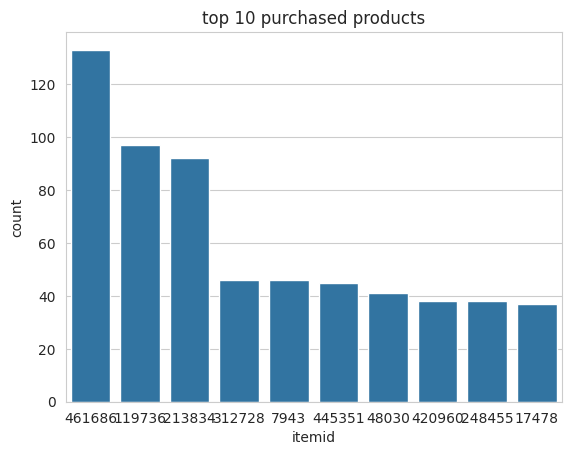

<Figure size 1000x600 with 0 Axes>

In [13]:
#top purchased products

top10 = pd.DataFrame(events[events['event']=='transaction'].groupby('itemid').size().sort_values(ascending=False).head(10).rename('count')).reset_index()
sns.barplot(top10, x='itemid', y='count', order=top10.sort_values('count', ascending=False).itemid)
plt.title('top 10 purchased products')
plt.figure(figsize=(10,6))
plt.show()

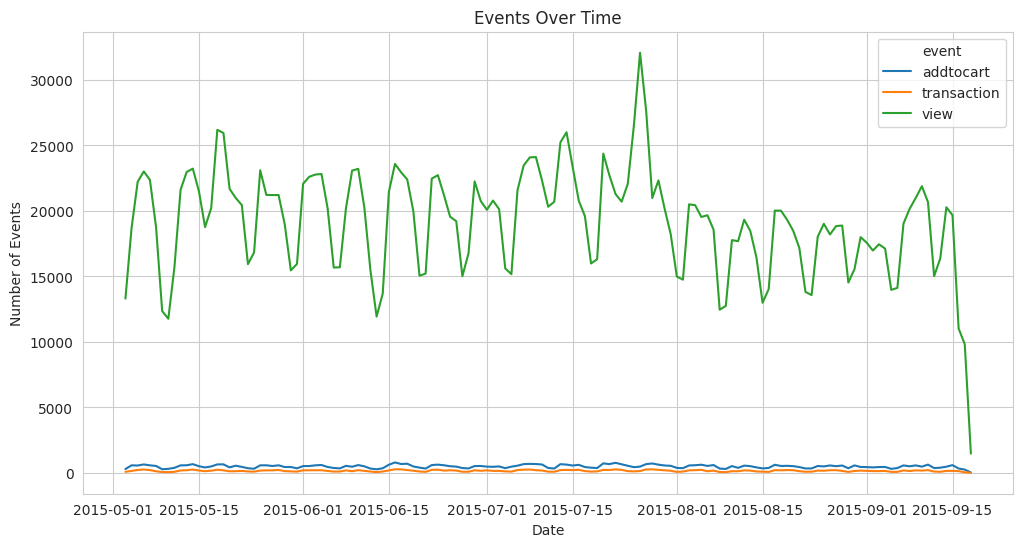

In [14]:
#time series


events['date'] = events['datetime'].dt.date
event_daily = events.groupby(['date', 'event']).size().reset_index().rename(columns={0:'count'})
plt.figure(figsize=(12, 6))
sns.lineplot(data=event_daily, x='date', y='count', hue='event')
plt.title('Events Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.show()

### 3. Approach I - Consider only Purchase

Rationale

**Relevance**: Purchase events indicate the items that users are genuinely interested in, as they have completed a transaction. <br>
**Predictive Power**: Items that users purchase are strong indicators of their preferences, making recommendations more accurate.<br>
**Data Noise Reduction**: Views and add-to-cart events can include exploratory or accidental actions, which might introduce noise into the recommendation system. <br>

In [15]:
events.event.value_counts()

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64

In [18]:
events.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,date
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,2015-06-02
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,2015-06-02
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,2015-06-02
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,2015-06-02
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,2015-06-02


In [21]:
events = events.merge(category_tree, left_on='itemid', right_on='categoryid', how='left')
events[events.parentid.notnull()].head()

,timestamp,visitorid,event,itemid,transactionid,datetime,date,categoryid,parentid
1335,1433164208740,819590,view,917,NaN,2015-06-01 13:10:08.740,2015-06-01,917.0,1374.0
1510,1433178025077,690286,view,1489,NaN,2015-06-01 17:00:25.077,2015-06-01,1489.0,1009.0
1913,1433198898166,994200,view,821,NaN,2015-06-01 22:48:18.166,2015-06-01,821.0,1012.0
2049,1433199274404,85734,view,821,NaN,2015-06-01 22:54:34.404,2015-06-01,821.0,1012.0
2625,1433143427043,503673,view,907,NaN,2015-06-01 07:23:47.043,2015-06-01,907.0,768.0


Convert the events data into user-item pair matrix

In [ ]:
# Filter out data to focus on purchases
purchases = events[events['event'] == 'transaction']

# Create a pivot table for user-item interactions
user_item_interaction = purchases.pivot_table(index='visitorid', columns='itemid', values='timestamp', aggfunc='count', fill_value=0)

In [ ]:
user_item_interaction.shape

In [ ]:
# plt.figure(figsize = (10,8))
# sns.heatmap(user_item_interaction, cmap = 'coolwarm')
# plt.show()

#very sparse matrix, visualization does not help much

#### 3.1 Surprise Package - DO NOT USE

In [22]:
#build recommendation system

! pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357258 sha256=ebe26ba0742475b37052ea55c802141537ef7c95da6eea515550bc341c42bc26
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [23]:
from surprise import Dataset, Reader

# Prepare the data in the format needed by surprise
reader = Reader(rating_scale=(1, 5)) # We use implicit ratings here; you might want to convert event counts to ratings
data = Dataset.load_from_df(purchases[['visitorid', 'itemid', 'timestamp']], reader)

NameError: name 'purchases' is not defined

You will also need a Reader object, but only **the rating_scale parameter must be specified. The dataframe must have three columns, corresponding to the user (raw) ids, the item (raw) ids, and the ratings in this order. Each row thus corresponds to a given rating**. This is not restrictive as you can reorder the columns of your dataframe easily.

In [ ]:
data #converted to a surprise dataset

In [ ]:
from surprise import SVD, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, BaselineOnly, NormalPredictor
from surprise.model_selection import cross_validate #cross validation method in surprise
from surprise.model_selection import train_test_split

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# List of algorithms built into Surprise to compare
algorithms = [
    SVD(),
    KNNBasic(),
    KNNWithMeans(),
    KNNWithZScore(),
    KNNBaseline(),
    BaselineOnly(),
    NormalPredictor()
]

# Dictionary to hold the cross-validation results for each algorithm
results = {}

for algorithm in algorithms:
    # Perform cross-validation
    cv_results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

    # Store the results
    results[algorithm.__class__.__name__] = cv_results #metric tracked

# Convert the results into a dataframe for easy comparison
results_df = pd.DataFrame(results).T
results_df['RMSE_mean'] = results_df['test_rmse'].apply(lambda x: x.mean())
results_df['MAE_mean'] = results_df['test_mae'].apply(lambda x: x.mean())
results_df[['RMSE_mean', 'MAE_mean']]

#### You can tell the error (MAE / RMSE) is huge, because we used the wrong package Surprise because **Surprice is scoped for only explicit ratings (1-5), Surprise do not support content-based data or implicit ratings**

Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.

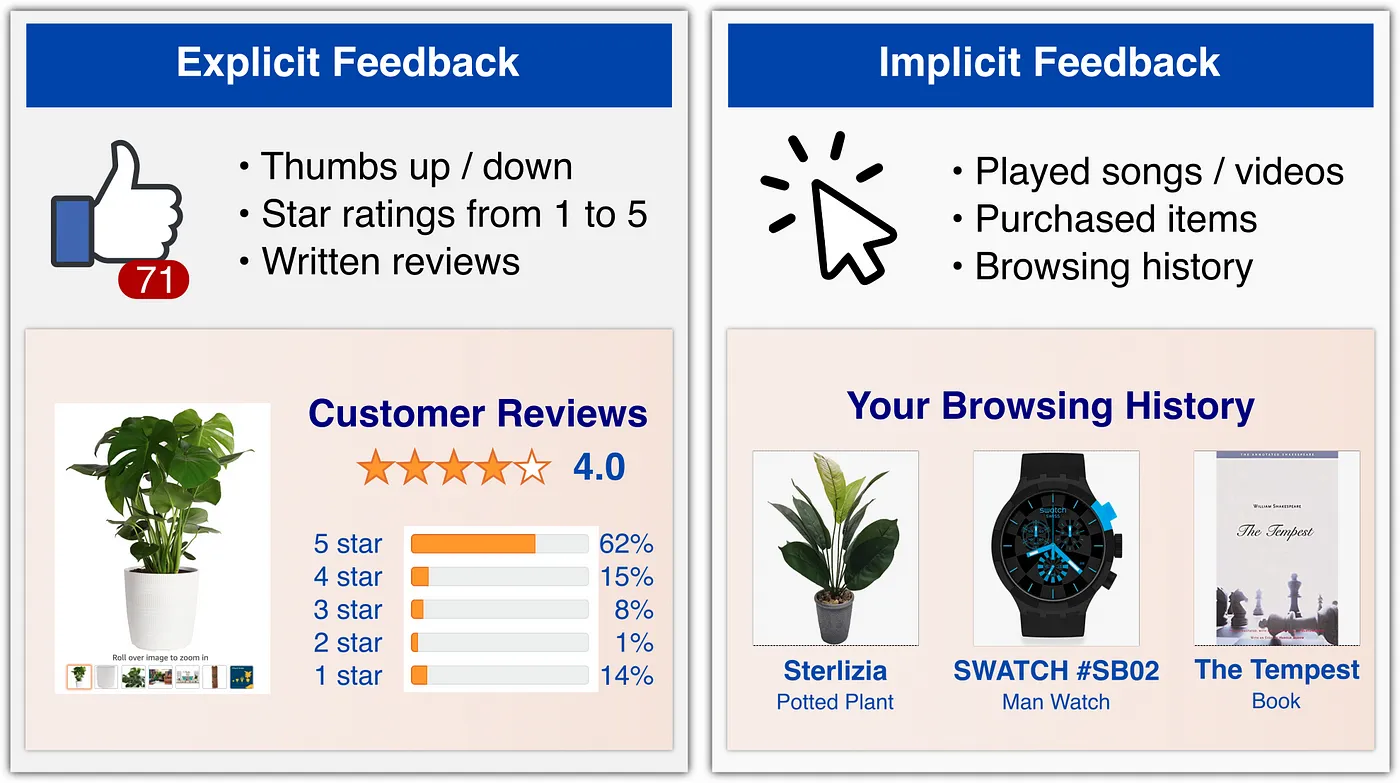

### What would be different approach to treat Explicit and Implicit data for recommendation?

#### 3.2 Recommender Package

In [ ]:
!pip install recommenders

In [ ]:
!pip install pyspark

In [ ]:
import sys
import pyspark

from recommenders.utils.spark_utils import start_or_get_spark
from recommenders.datasets.download_utils import maybe_download
from recommenders.datasets.python_splitters import (
    python_random_split,
    python_chrono_split,
    python_stratified_split
)
from recommenders.datasets.spark_splitters import spark_random_split

print(f"System version: {sys.version}")
print(f"Pyspark version: {pyspark.__version__}")